## Food Delivery | Linear Regression, RANSAC, Lasso, Ridge, Elastic Net

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import seaborn as sns
import numpy as np
import itertools
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RANSACRegressor, Lasso, Ridge, ElasticNet
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv('Documents/Python/ml-projects/data/Food_Delivery_Times.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


In [4]:
df.describe()

,Order_ID,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
count,1000.000000,1000.000000,1000.000000,970.000000,1000.000000
mean,500.500000,10.059970,16.982000,4.579381,56.732000
std,288.819436,5.696656,7.204553,2.914394,22.070915
min,1.000000,0.590000,5.000000,0.000000,8.000000
25%,250.750000,5.105000,11.000000,2.000000,41.000000
50%,500.500000,10.190000,17.000000,5.000000,55.500000
75%,750.250000,15.017500,23.000000,7.000000,71.000000
max,1000.000000,19.990000,29.000000,9.000000,153.000000


In [5]:
df.duplicated().sum()

0

In [6]:
df.isnull().sum()

Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64

In [7]:
df.dropna(inplace=True)

In [8]:
df.isnull().sum()

Order_ID                  0
Distance_km               0
Weather                   0
Traffic_Level             0
Time_of_Day               0
Vehicle_Type              0
Preparation_Time_min      0
Courier_Experience_yrs    0
Delivery_Time_min         0
dtype: int64

### Data visualisation

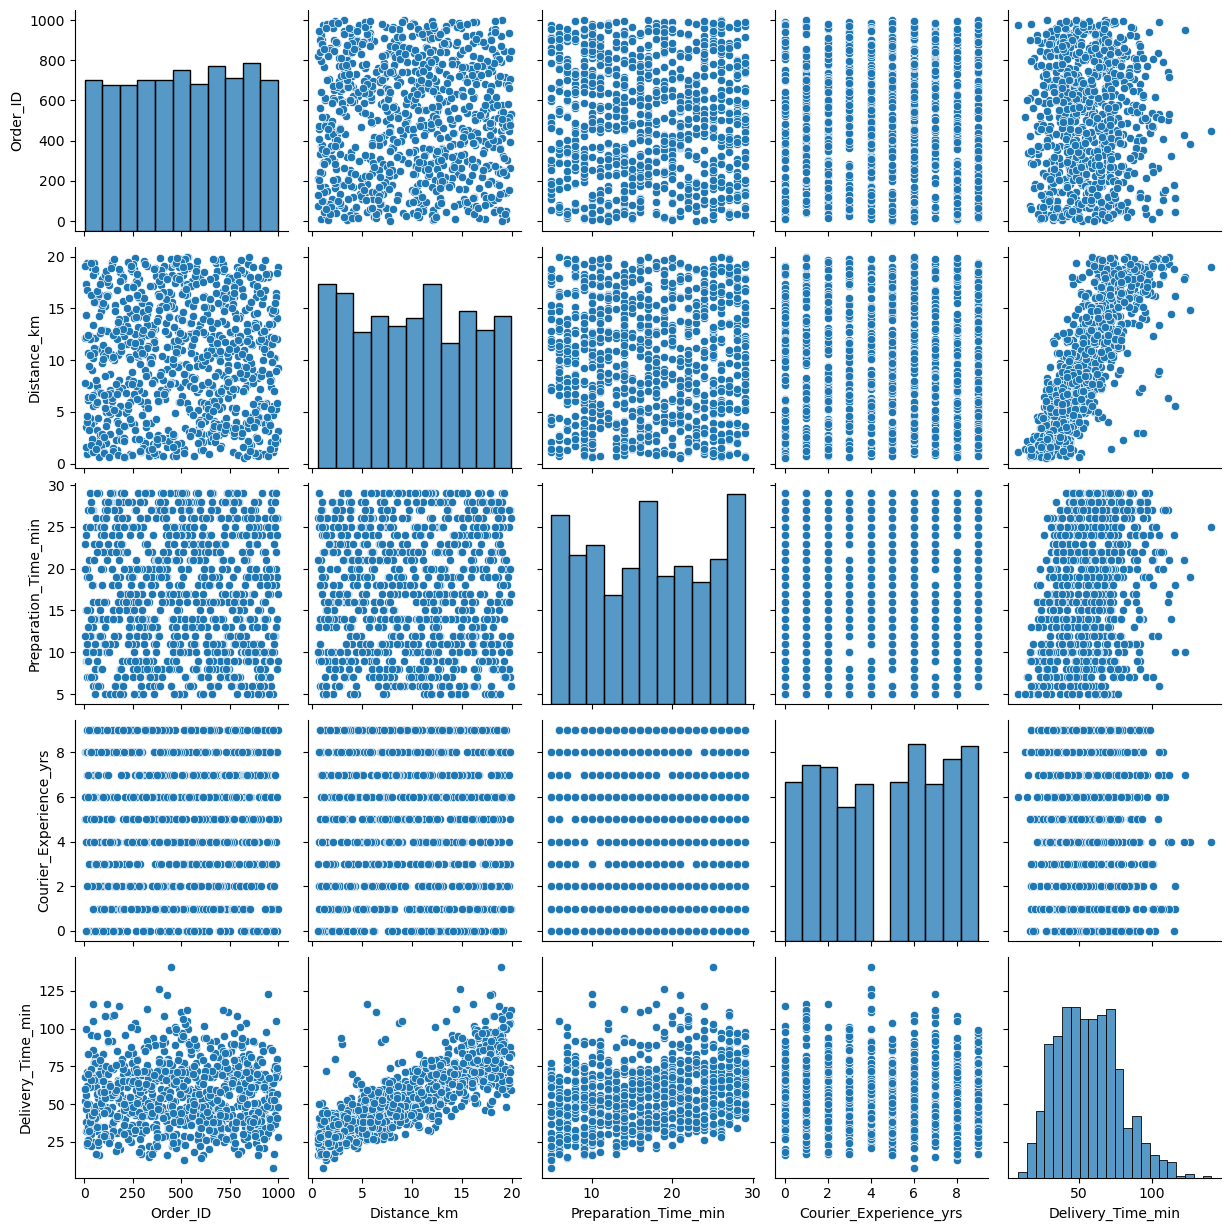

In [18]:
# Check the data distribution between pairs

sns.pairplot(df)
plt.show()

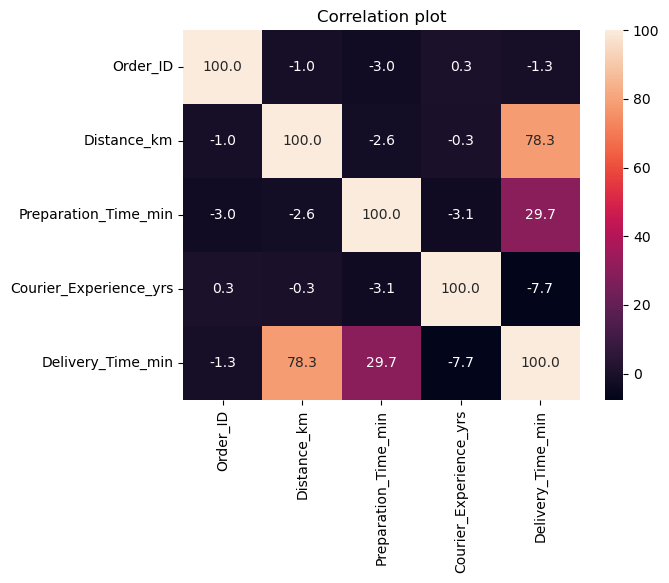

In [19]:
# Check the features correlation

corr = df.select_dtypes(include='number').corr() * 100
sns.heatmap(corr, annot=True, fmt='.1f')
plt.title('Correlation plot')
plt.show()

In [20]:
# Delete order ID number 
del df['Order_ID']

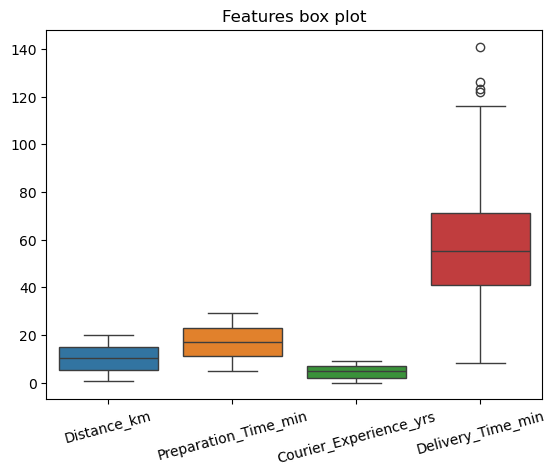

In [21]:
# Check if data contains outliers
sns.boxplot(df)
plt.title('Features box plot')
plt.xticks(rotation=15)
plt.show()

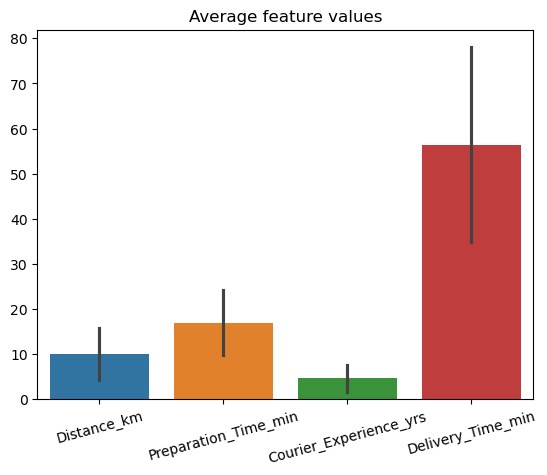

In [22]:
sns.barplot(data=df, errorbar='sd')
plt.title('Average feature values')
plt.xticks(rotation=15)
plt.show()

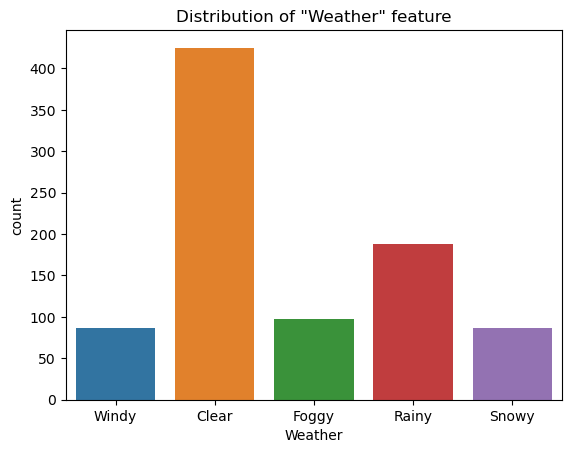

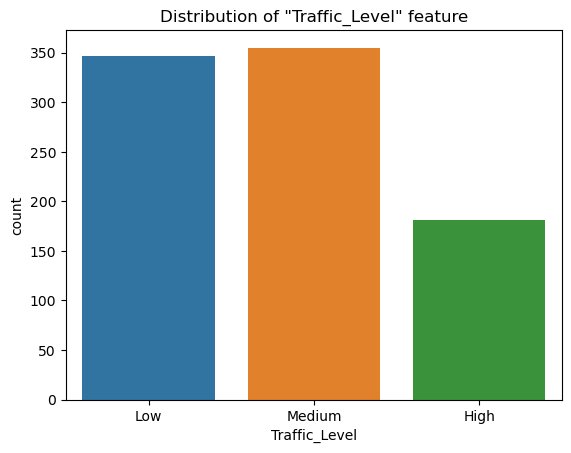

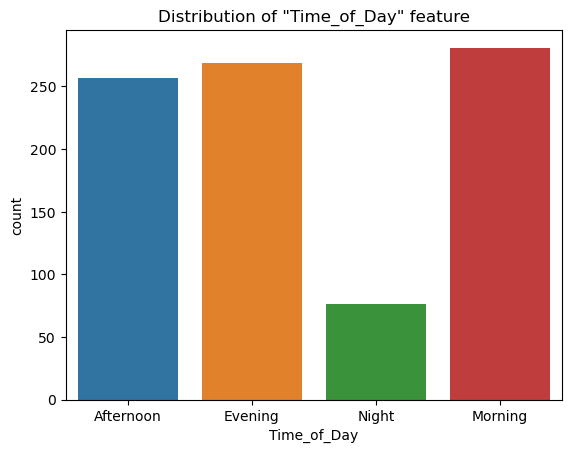

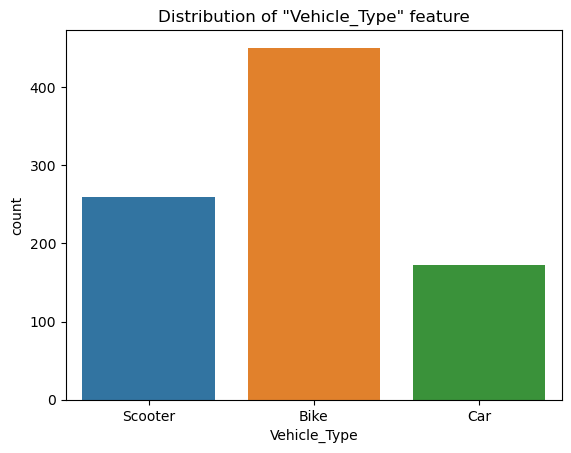

In [23]:
for col in df.select_dtypes(include='object'):
    sns.countplot(data=df, x=col, hue=col)
    plt.title(f'Distribution of "{col}" feature')
    plt.show()

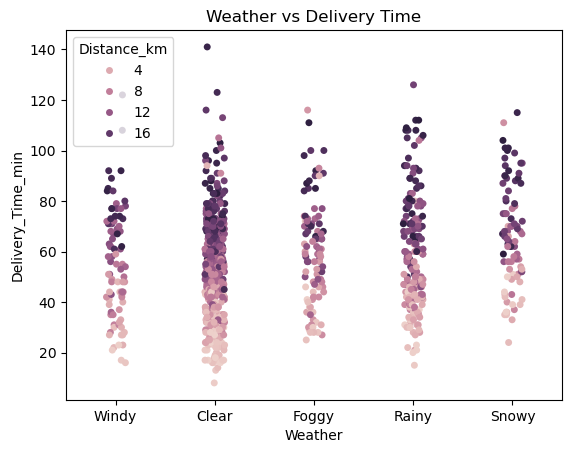

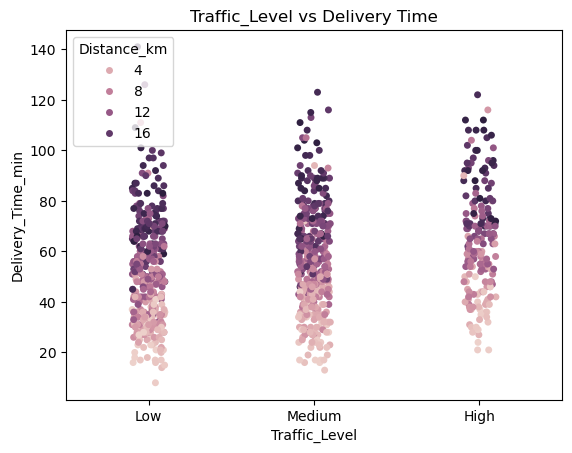

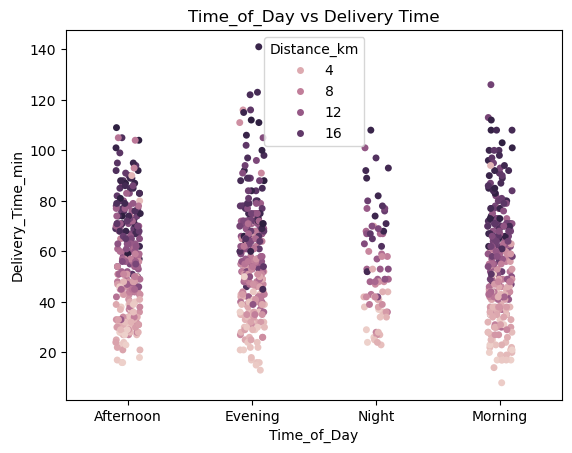

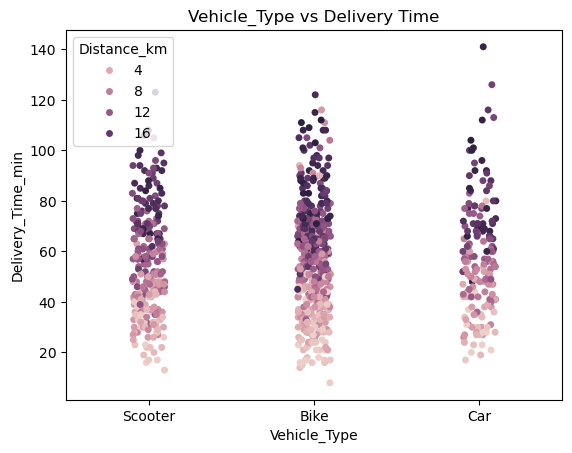

In [24]:
for cat in df.select_dtypes(include='object'):
    sns.stripplot(data=df, x=cat, y='Delivery_Time_min', hue='Distance_km')
    plt.title(f'{cat} vs Delivery Time')
    plt.show()

### Data preparation

In [33]:
df_dummies = pd.get_dummies(df, columns=['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type'], drop_first=True)

df_std = df_dummies.copy()

In [35]:
sc = StandardScaler()
sc.fit(df_std[df.select_dtypes('number').columns])
df_std[df.select_dtypes('number').columns] = sc.transform(df_std[df.select_dtypes('number').columns])

In [37]:
x = df_std.copy()
x.drop('Delivery_Time_min', axis=1, inplace=True)

y = df_std['Delivery_Time_min']

In [44]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

### Linear Regression

In [47]:
lr = LinearRegression()
lr.fit(x_train, y_train)
lr.score(x_test, y_test)

0.8289602718749691

In [49]:
lr_r2_score = r2_score(y_test, lr.predict(x_test))
lr_r2_score

0.8289602718749691

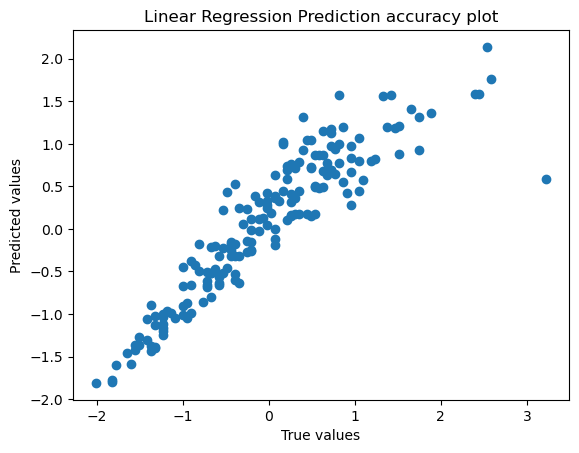

In [51]:
plt.scatter(y_test, lr.predict(x_test))
plt.title('Linear Regression Prediction accuracy plot')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.show()

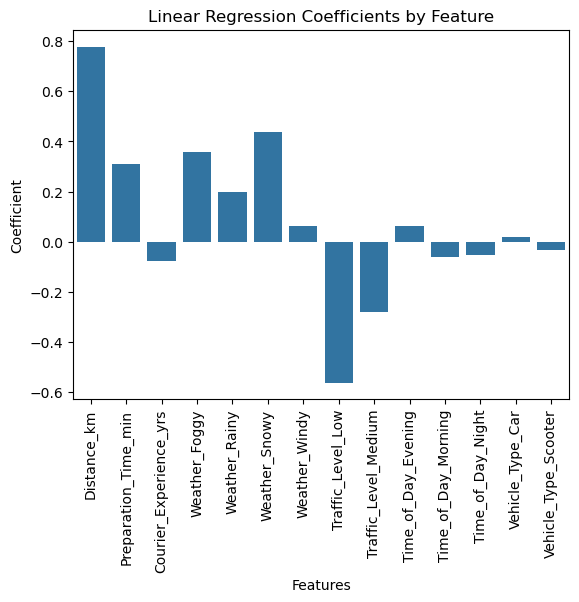

In [53]:
sns.barplot(x=range(len(lr.coef_)), y=lr.coef_)
plt.title('Linear Regression Coefficients by Feature')
plt.xticks(ticks=range(len(lr.coef_)), labels=list(x.columns), rotation=90)
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.show()

### RANSAC

In [56]:
ransac = RANSACRegressor(estimator=LinearRegression(),
                         min_samples=0.6)

ransac.fit(x_train, y_train)
ransac.score(x_test, y_test)

0.8443064226244911

In [58]:
ransac_r2_score = r2_score(y_test, ransac.predict(x_test))
ransac_r2_score

0.8443064226244911

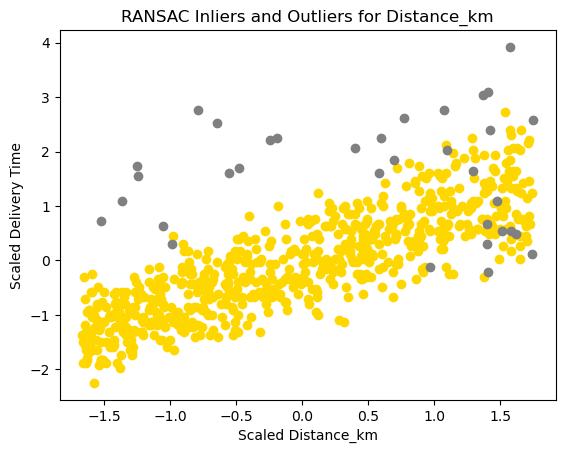

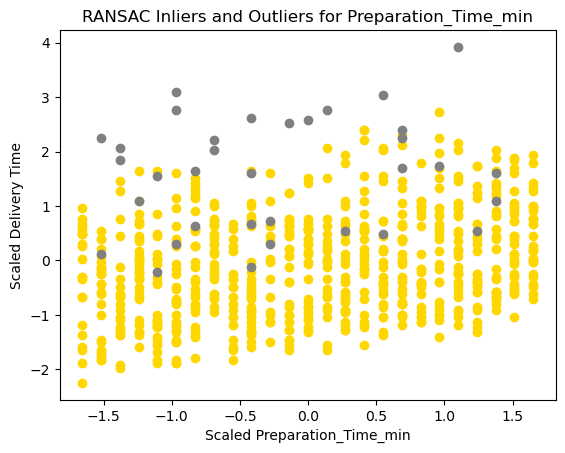

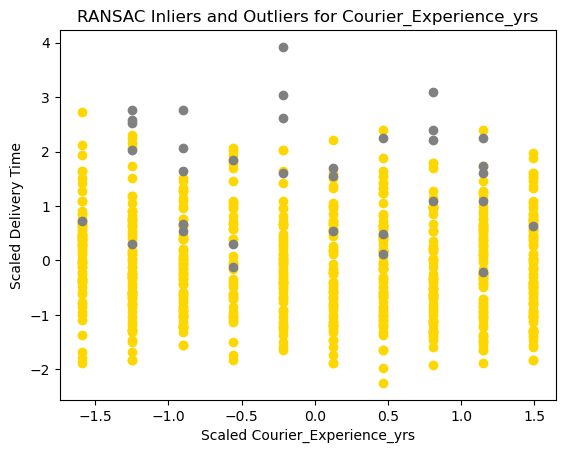

In [60]:
inliner_mask = ransac.inlier_mask_

for col in ['Distance_km', 'Preparation_Time_min', 'Courier_Experience_yrs']:
    plt.scatter(x_train[col][inliner_mask], y_train[inliner_mask], c='gold')
    plt.scatter(x_train[col][~inliner_mask], y_train[~inliner_mask], c='gray')
    plt.title(f'RANSAC Inliers and Outliers for {col}')
    plt.xlabel(f'Scaled {col}')
    plt.ylabel(f'Scaled Delivery Time')
    plt.show()

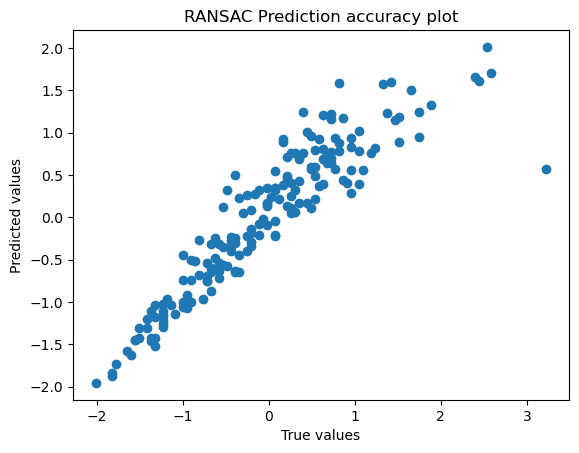

In [62]:
plt.scatter(y_test, ransac.predict(x_test))
plt.title('RANSAC Prediction accuracy plot')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.show()

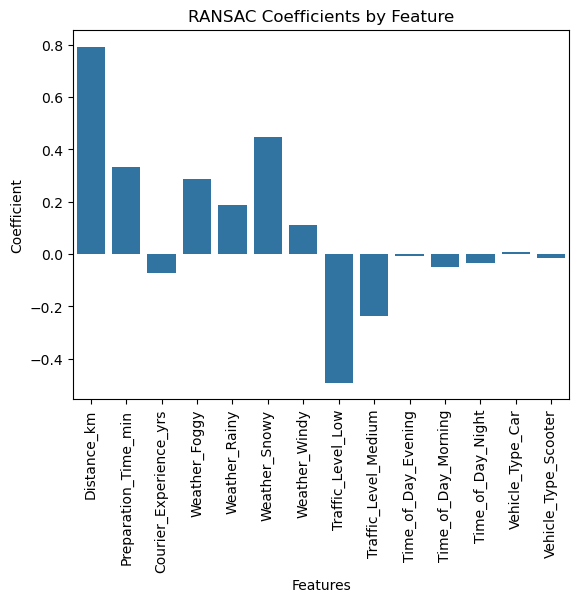

In [64]:
sns.barplot(x=range(len(ransac.estimator_.coef_)), y=ransac.estimator_.coef_)
plt.title('RANSAC Coefficients by Feature')
plt.xticks(ticks=range(len(ransac.estimator_.coef_)), labels=x.columns, rotation=90)
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.show()

### LASSO

In [67]:
lasso = Lasso(alpha=0.01)
lasso.fit(x_train, y_train)
lasso.score(x_test, y_test)

0.8188292142904591

In [69]:
lasso_results = pd.DataFrame({'alpha': np.arange(0.001, 0.101, 0.001),
                              'r2_score': None,
                              'no_of_features': None})

In [71]:
lasso_r2_score = 0
for i in range(len(lasso_results)):
    alpha = lasso_results.loc[i, 'alpha']
    lasso_tmp = Lasso(alpha=alpha)
    lasso_tmp.fit(x_train, y_train)
    lasso_tmp_r2_score = r2_score(y_test, lasso_tmp.predict(x_test))
    
    lasso_results.loc[i, 'r2_score'] = lasso_tmp_r2_score
    lasso_results.loc[i, 'no_of_features'] = np.count_nonzero(lasso_tmp.coef_)
    
    if lasso_tmp_r2_score > lasso_r2_score:
        lasso_r2_score = lasso_tmp_r2_score
        lasso = lasso_tmp

lasso_r2_score

0.8281757554327693

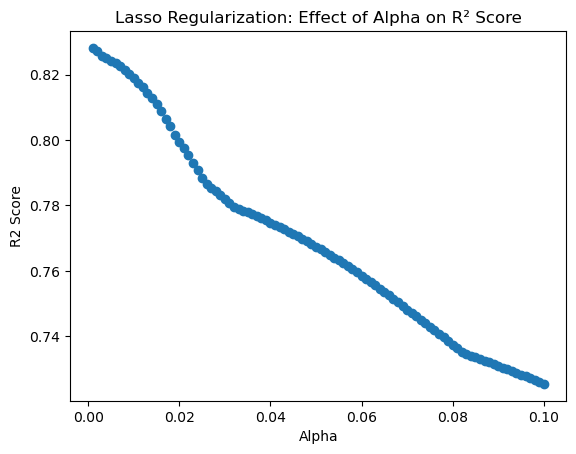

In [73]:
plt.scatter(x= lasso_results['alpha'], y=lasso_results['r2_score'])
plt.title('Lasso Regularization: Effect of Alpha on R² Score')
plt.xlabel('Alpha')
plt.ylabel('R2 Score')
plt.show()

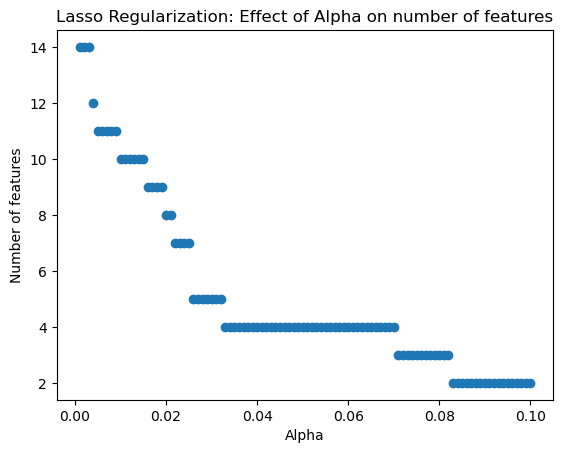

In [75]:
plt.scatter(x= lasso_results['alpha'], y=lasso_results['no_of_features'])
plt.title('Lasso Regularization: Effect of Alpha on number of features')
plt.xlabel('Alpha')
plt.ylabel('Number of features')
plt.show()

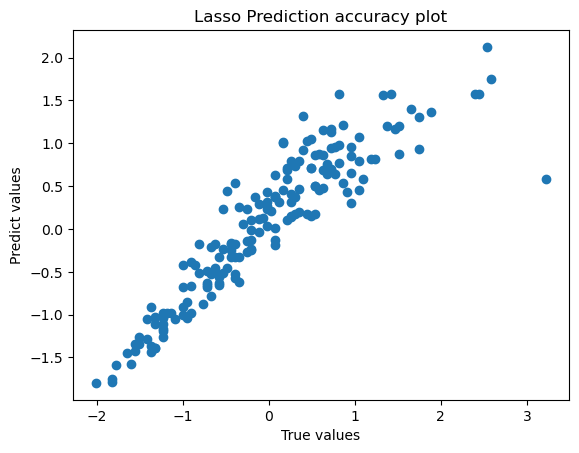

In [77]:
plt.scatter(x=y_test, y=lasso.predict(x_test))
plt.title('Lasso Prediction accuracy plot')
plt.xlabel('True values')
plt.ylabel('Predict values')
plt.show()

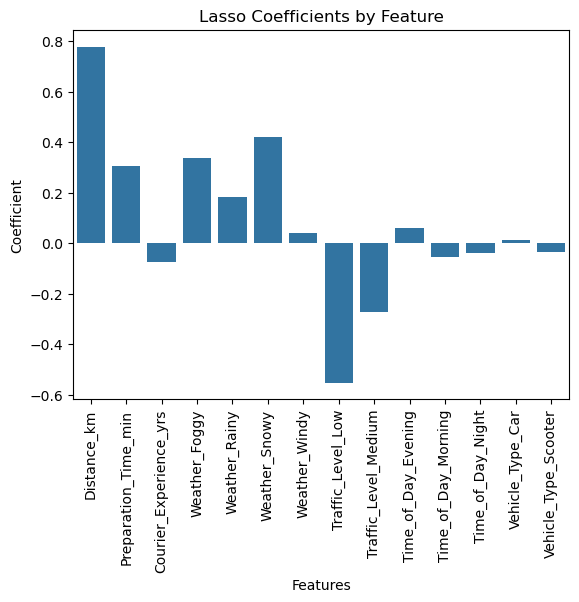

In [79]:
sns.barplot(x=range(len(lasso.coef_)), y=lasso.coef_)
plt.title('Lasso Coefficients by Feature')
plt.xticks(ticks=range(len(lasso.coef_)), labels=x.columns, rotation=90)
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.show()

### Ridge

In [82]:
ridge = Ridge(alpha=500)
ridge.fit(x_train, y_train)
ridge.score(x_test, y_test)

0.639249694147481

In [84]:
ridge_results = pd.DataFrame({'alpha': np.arange(0, 100, 2),
                              'r2_score': None,
                              'no_of_features': None})

In [86]:
ridge_r2_score = 0
for i in range(len(ridge_results)):
    alpha = ridge_results.loc[i, 'alpha']
    ridge_tmp = Ridge(alpha=alpha)
    ridge_tmp.fit(x_train, y_train)
    ridge_tmp_r2_score = r2_score(y_test, ridge_tmp.predict(x_test))
    
    ridge_results.loc[i, 'r2_score'] = ridge_tmp_r2_score
    ridge_results.loc[i, 'no_of_features'] = np.count_nonzero(ridge_tmp.coef_)
    
    if ridge_tmp_r2_score > ridge_r2_score:
        ridge_r2_score = ridge_tmp_r2_score
        ridge = ridge_tmp

ridge_r2_score

0.8289602718749691

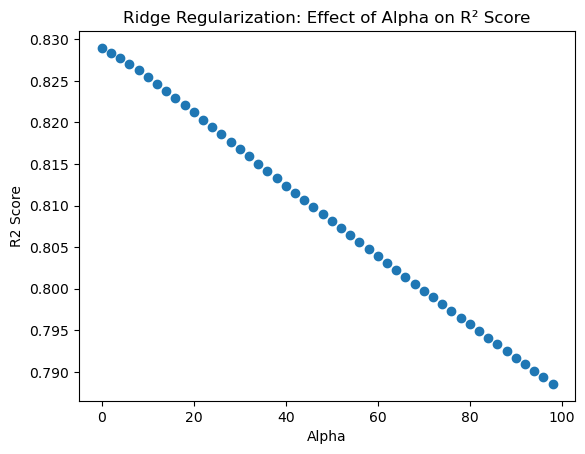

In [88]:
plt.scatter(x=ridge_results['alpha'], y=ridge_results['r2_score'])
plt.title('Ridge Regularization: Effect of Alpha on R² Score')
plt.xlabel('Alpha')
plt.ylabel('R2 Score')
plt.show()

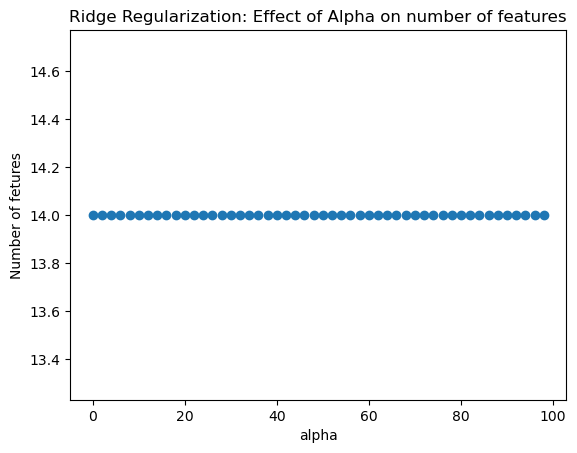

In [90]:
plt.scatter(x=ridge_results['alpha'], y=ridge_results['no_of_features'])
plt.title('Ridge Regularization: Effect of Alpha on number of features')
plt.xlabel('alpha')
plt.ylabel('Number of fetures')
plt.show()

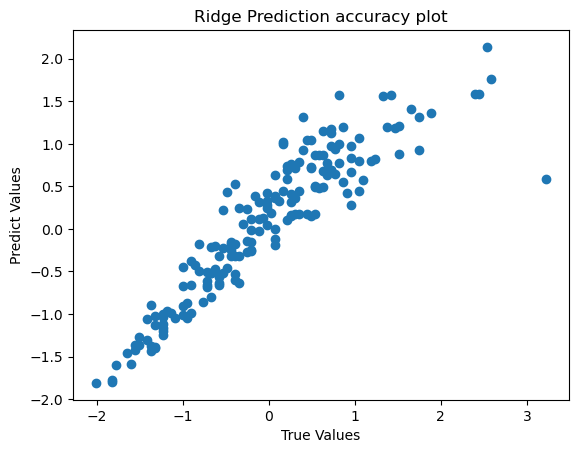

In [92]:
plt.scatter(x=y_test, y=ridge.predict(x_test))
plt.title('Ridge Prediction accuracy plot')
plt.xlabel('True Values')
plt.ylabel('Predict Values')
plt.show()

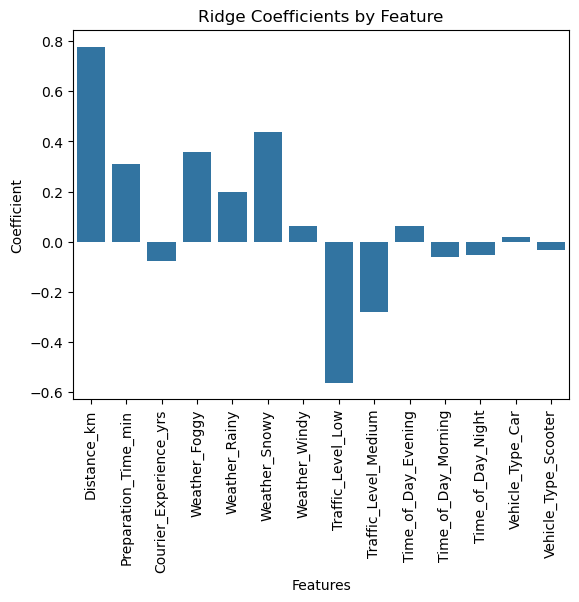

In [94]:
sns.barplot(x=range(len(ridge.coef_)), y=ridge.coef_)
plt.xticks(ticks=range(len(ridge.coef_)), labels=x.columns, rotation=90)
plt.title('Ridge Coefficients by Feature')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.show()

### ElasticNet

In [97]:
elastic = ElasticNet(alpha=0.01, l1_ratio=0.3)
elastic.fit(x_train, y_train)
elastic.score(x_test, y_test)

0.8238430134594924

In [99]:
alphas = np.arange(0.001, 0.2, 0.01)
ratios = np.arange(0.01, 0.3, 0.01)
param_combinations = list(itertools.product(alphas, ratios))

elastic_results = pd.DataFrame(param_combinations, columns=['alpha', 'ratio'])
elastic_results['r2_score'] = None
elastic_results['no_of_features'] = None

In [101]:
elastic_r2_score = 0
for i in range(len(elastic_results)):
    alpha = elastic_results.loc[i,'alpha']
    ratio = elastic_results.loc[i, 'ratio']
    
    elastic_tmp = ElasticNet(alpha=alpha, l1_ratio=ratio)
    elastic_tmp.fit(x_train, y_train)
    elastic_tmp_r2_score = r2_score(y_test, elastic_tmp.predict(x_test))
    
    elastic_results.loc[i, 'r2_score'] = elastic_tmp_r2_score
    elastic_results.loc[i, 'no_of_features'] = np.count_nonzero(elastic_tmp.coef_)
    
    if elastic_tmp_r2_score > elastic_r2_score:
        elastic_r2_score = elastic_tmp_r2_score
        elastic = elastic_tmp

elastic_r2_score

0.8287624372971565

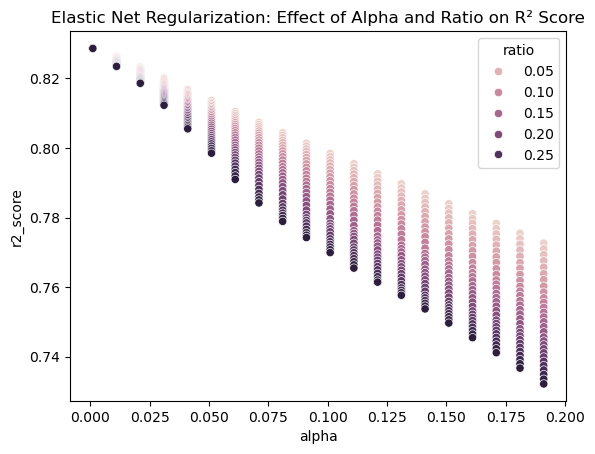

In [102]:
sns.scatterplot(elastic_results, x='alpha', y='r2_score', hue='ratio')
plt.title('Elastic Net Regularization: Effect of Alpha and Ratio on R² Score')
plt.show()

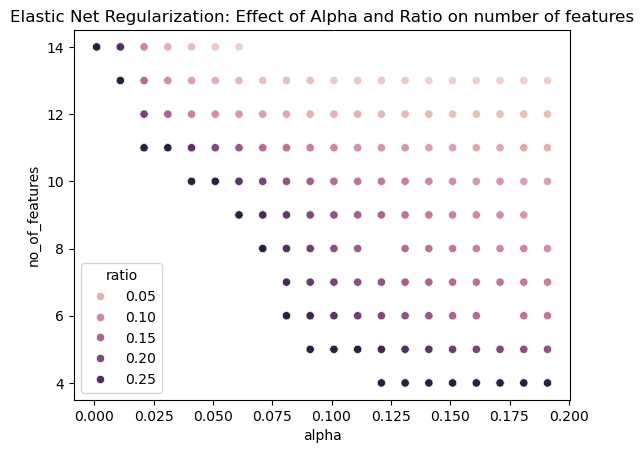

In [105]:
sns.scatterplot(elastic_results, x='alpha', y='no_of_features', hue='ratio')
plt.title('Elastic Net Regularization: Effect of Alpha and Ratio on number of features')
plt.show()

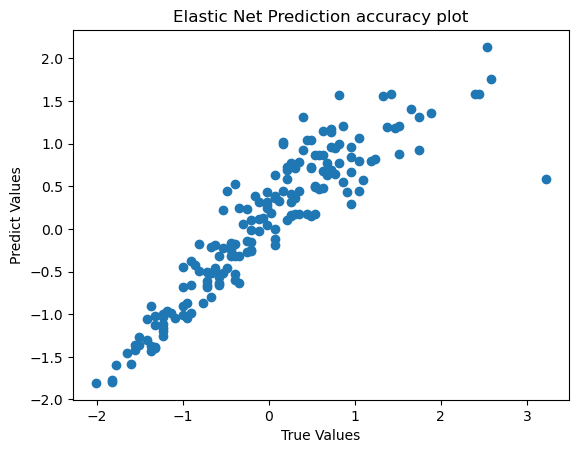

In [107]:
plt.scatter(x=y_test, y=elastic.predict(x_test))
plt.title('Elastic Net Prediction accuracy plot')
plt.xlabel('True Values')
plt.ylabel('Predict Values')
plt.show()

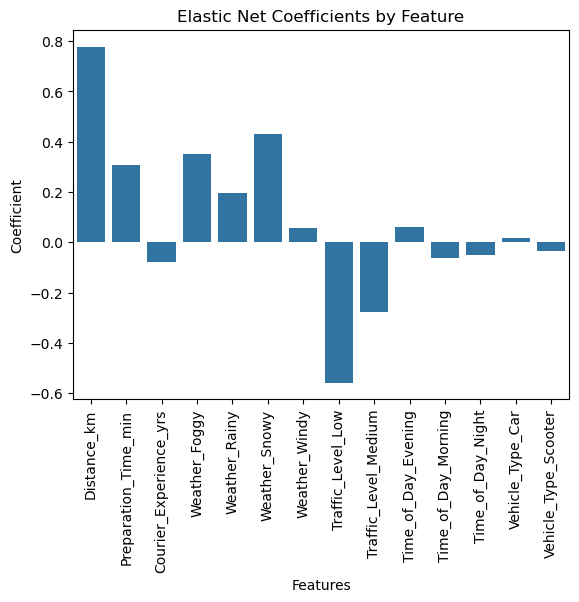

In [109]:
sns.barplot(x=range(len(elastic.coef_)), y=elastic.coef_)
plt.xticks(ticks=range(len(ridge.coef_)), labels=x.columns, rotation=90)
plt.title('Elastic Net Coefficients by Feature')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.show()

### Models compare

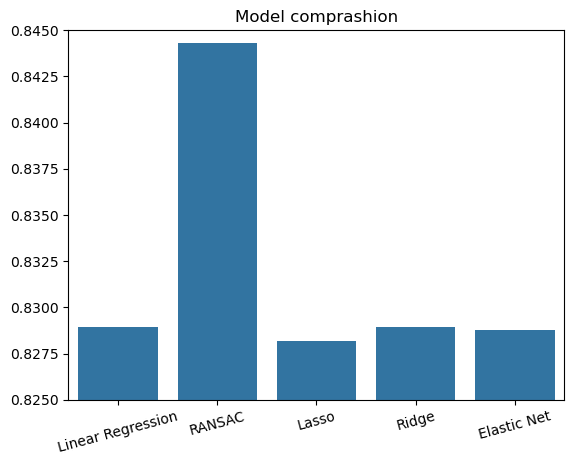

In [120]:
sns.barplot(x=['Linear Regression', 'RANSAC', 'Lasso', 'Ridge', 'Elastic Net'],
            y=[lr_r2_score, ransac_r2_score, lasso_r2_score, ridge_r2_score, elastic_r2_score])
plt.title('Model comprashion')
plt.xticks(rotation=15)
plt.ylim(0.825, 0.845)
plt.show()